# <div align="center"> SPECIAL TOPICS III </div>
## <div align="center"> Data Science for Social Scientists  </div>
### <div align="center"> ECO 4199 </div>
#### <div align="center">Class 7 - Model Selection</div>
<div align="center"> Fabien Forge, (he/him)</div>

# Roadmap

- In the last lecture we saw the risk associated with overfitting. 
- Although we discussed the case of polynomial regressions, the risk of overfitting is common to all learning models
- This risk usually increases with the number of parameters
$$ Y = f(\mathbf{X}) + \varepsilon$$
- Regression and classification used tools that you were already familiar with (at least to some extent)
- But we only scratched the surface of what these functions may look like
- Today, we will keep using these tools with a different goal in mind
- This goal will require new tools...

## Dealing with overfitting
- Last lecture, we saw the issues associated with overfitting
- You may think that the issue came from allowing for (undue) higher degrees in our model
- But the issue is broader than this.
- We used a model in which Y was related to $X$ and $X^2$ not $X^n$ for n>2
- In other words we were using too many predictors

## RSS and MSE
- the training set MSE is generally an underestimate of the test MSE. 
    - Recall that MSE = RSS/n. 
- When we fit a model to the training data using least squares, we specifically estimate the regression coefficients such that the training RSS (but not the test RSS) is as small as possible. 
- In particular, the training error will decrease as more variables are included in the model, but the test error may not.
- Therefore, training set RSS and training set R2 cannot be used to select from among a set of models with different numbers of variables.
- However, a number of techniques for adjusting the training error for the model size are available.

# Subset Selection
$$Y = \beta_0+\beta_1X_1+\beta_2X_2+ ... + \beta_pX_p + \epsilon$$
- The issue it that adding predictors will always weakly improve the in sample prediction
    - But at the expense of out of sample prediction
- It is therefore important to limit the number of predictors to those actually related to Y
- __Subset Selection__ _is the process of identifying the p predictors actually related to Y._

## Best Subset Selection
- Here is the algorithm to select the best subset given a dataset with p predictors
- We will apply this algorithm to the Credit dataset

Algorithm:

1. Let $\mathscr{M}_0$ denote the null model , which contains no predictors. This
model simply predicts the sample mean for each observation.
2. For k = 1, 2, . . .p:
    - a. Fit all ${P\choose k}$ containing exactly $k$ predictors
    - b. Pick the best among these ${P\choose k}$ and call it $\mathscr{M}_k$. Here best is defined as having the smallest RSS, or equivalently largest R2.
3. Select a single best model from among $\mathscr{M}_0$, . . . ,$\mathscr{M}_p$ using crossvalidated prediction error (MSE), AIC, BIC, or adjusted $R^2$

### The null model
- Let's start with the null model
- This a model using no predictors and a single parameter: the intercept

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn.linear_model as skl_lm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import time
import itertools


folderPath="~/Dropbox/Data Science for Social Scientists/Classes/Class 7 – Model Selection/"

In [2]:
df=pd.read_csv("Credit.csv" ,usecols=list(range(1,12)))
df['Gender']=df['Gender'].replace({" Male":0,  "Female":1})
df['Student']=df['Student'].replace({"No":0,  "Yes":1})
df['Married']=df['Married'].replace({"No":0,  "Yes":1})
df=df.join(pd.get_dummies(df['Ethnicity'], drop_first=True))
df.pop("Ethnicity")
display(df.shape)
df.head()

(400, 12)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Asian,Caucasian
0,14.891,3606,283,2,34,11,0,0,1,333,0,1
1,106.025,6645,483,3,82,15,1,1,1,903,1,0
2,104.593,7075,514,4,71,11,0,0,0,580,1,0
3,148.924,9504,681,3,36,11,1,0,0,964,1,0
4,55.882,4897,357,2,68,16,0,0,1,331,0,1


$\mathscr{M}_0$

In [3]:
# M0
results = smf.ols('Balance ~ 1 ', data=df).fit()
# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 09 Nov 2021   Prob (F-statistic):                nan
Time:                        11:18:17   Log-Likelihood:                -3019.4
No. Observations:                 400   AIC:                             6041.
Df Residuals:                     399   BIC:                             6045.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    520.0150     22.988     22.621      0.0

In [4]:
df['Balance'].mean()

520.015

In [5]:
# get y and X
y=df['Balance'] # y
X=df.loc[:,~df.columns.str.contains('Balance')] # X
X['intercept']=1
X.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Asian,Caucasian,intercept
0,14.891,3606,283,2,34,11,0,0,1,0,1,1
1,106.025,6645,483,3,82,15,1,1,1,1,0,1
2,104.593,7075,514,4,71,11,0,0,0,1,0,1
3,148.924,9504,681,3,36,11,1,0,0,1,0,1
4,55.882,4897,357,2,68,16,0,0,1,0,1,1


$\mathscr{M}_1$

In [6]:
# initiate empty list to store R2
R2= 0
best_predictor="none"
X=df.loc[:,~df.columns.str.contains('Balance')]
y=df.loc[:,df.columns.str.contains('Balance')]

# for each predictor in X
for k in range(X.shape[1]-1): 
    results = sm.OLS(y, X.iloc[:,[k,-1]]).fit() # fit predictor in position p and intercept (in last position, -1)
    print(f"R\u00b2 for predictor {X.columns[k]} is {round(results.rsquared,6):f}")
    if results.rsquared>R2:
        R2=results.rsquared ; best_predictor=X.columns[k]
print("\nBest predictor for M1 is: {} with R\u00b2= {}.".format(best_predictor,round(R2,3)))

R² for predictor Income is 0.622637
R² for predictor Limit is 0.858626
R² for predictor Rating is 0.845239
R² for predictor Cards is 0.506125
R² for predictor Age is 0.516919
R² for predictor Education is 0.533170
R² for predictor Gender is 0.385951
R² for predictor Student is 0.370826
R² for predictor Married is 0.400392
R² for predictor Asian is 0.416977

Best predictor for M1 is: Limit with R²= 0.859.


# Beyond $\mathscr{M}_1$



In [7]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate R-squared
    regr = sm.OLS(y,sm.add_constant(X[list(feature_set)])).fit()
    return {"model_R2":regr, "R2":regr.rsquared}

In [8]:
def getBest(k):
    tic = time.time()
    results = [] # empty list of results
    for combo in itertools.combinations(X.columns, k): # k combinations of columns in X
        results.append(processSubset(combo))
    
    # Put results in dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest R2
    best_model = models.loc[models['R2'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [9]:
models_best_R2 = pd.DataFrame(columns=["R2", "model_R2"])

tic = time.time()
for i in range(1,X.shape[1]+1):
    models_best_R2.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
models_best_R2

Processed 11 models on 1 predictors in 0.024087905883789062 seconds.
Processed 55 models on 2 predictors in 0.16127276420593262 seconds.
Processed 165 models on 3 predictors in 0.32370615005493164 seconds.
Processed 330 models on 4 predictors in 0.6226258277893066 seconds.
Processed 462 models on 5 predictors in 0.9621639251708984 seconds.
Processed 462 models on 6 predictors in 0.997758150100708 seconds.
Processed 330 models on 7 predictors in 0.6197366714477539 seconds.
Processed 165 models on 8 predictors in 0.3255290985107422 seconds.
Processed 55 models on 9 predictors in 0.1053171157836914 seconds.
Processed 11 models on 10 predictors in 0.024386167526245117 seconds.
Processed 1 models on 11 predictors in 0.0032358169555664062 seconds.
Total elapsed time: 4.196227073669434 seconds.


,R2,model_R2
1,0.745848,<statsmodels.regression.linear_model.Regressio...
2,0.875118,<statsmodels.regression.linear_model.Regressio...
3,0.949879,<statsmodels.regression.linear_model.Regressio...
4,0.953580,<statsmodels.regression.linear_model.Regressio...
5,0.954161,<statsmodels.regression.linear_model.Regressio...
6,0.954688,<statsmodels.regression.linear_model.Regressio...
7,0.954817,<statsmodels.regression.linear_model.Regressio...
8,0.954888,<statsmodels.regression.linear_model.Regressio...
9,0.954964,<statsmodels.regression.linear_model.Regressio...
10,0.955047,<statsmodels.regression.linear_model.Regressio...


![title](credit_10predictors.png)

## Akaike information criterion (AIC)

- The AIC criterion is defined for a large class of models fit by maximum likelihood. 
    - Recall that OLS regressions are a subset of maximum likelihood
- For a fitted least squares model containing p predictors
$$\large \text{AIC}=\frac{1}{n\hat{\sigma}^2}(\text{RSS} + 2p\hat{\sigma}^2)$$
- Also, recall that MSE is defined as $\frac{1}{n} \text{RSS}$

## Akaike information criterion (AIC), continued
- $\hat{\sigma}^2$ is an estimate of the variance of the error $\varepsilon$ associated with each response measurement 
- $2p\hat{\sigma}^2$  is a statistical penalty on the training RSS
    - In order to account for the fact that training error tends to underestimate the test error
    - The penalty increases with the number of predictors $p$ to adjust for the corresponding decrease in training RSS
- Smaller values of AIC indicates better fit

In [10]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate aic
    regr = sm.OLS(y,sm.add_constant(X[list(feature_set)])).fit()
    return {"model_aic":regr, "AIC":regr.aic}

def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest R2
    best_model = models.loc[models['AIC'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [11]:
models_best_aic = pd.DataFrame(columns=["AIC", "model_aic"])

tic = time.time()
print(X.shape[1])
for i in range(1,X.shape[1]+1):
    models_best_aic.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
models_best_aic

11
Processed 11 models on 1 predictors in 0.02089095115661621 seconds.
Processed 55 models on 2 predictors in 0.08430695533752441 seconds.
Processed 165 models on 3 predictors in 0.23648905754089355 seconds.
Processed 330 models on 4 predictors in 0.6045176982879639 seconds.
Processed 462 models on 5 predictors in 0.8693640232086182 seconds.
Processed 462 models on 6 predictors in 0.9153439998626709 seconds.
Processed 330 models on 7 predictors in 0.6141958236694336 seconds.
Processed 165 models on 8 predictors in 0.49970483779907227 seconds.
Processed 55 models on 9 predictors in 0.1087348461151123 seconds.
Processed 11 models on 10 predictors in 0.023408889770507812 seconds.
Processed 1 models on 11 predictors in 0.002801179885864258 seconds.
Total elapsed time: 4.003463268280029 seconds.


,AIC,model_aic
1,5494.781548,<statsmodels.regression.linear_model.Regressio...
2,5212.557085,<statsmodels.regression.linear_model.Regressio...
3,4849.386992,<statsmodels.regression.linear_model.Regressio...
4,4820.701337,<statsmodels.regression.linear_model.Regressio...
5,4817.666820,<statsmodels.regression.linear_model.Regressio...
6,4815.038963,<statsmodels.regression.linear_model.Regressio...
7,4815.900560,<statsmodels.regression.linear_model.Regressio...
8,4817.268900,<statsmodels.regression.linear_model.Regressio...
9,4818.597738,<statsmodels.regression.linear_model.Regressio...
10,4819.857603,<statsmodels.regression.linear_model.Regressio...


## Bayesian information criterion (BIC)
$$\large \text{BIC}=\frac{1}{n\hat{\sigma}^2}(\text{RSS} + \log(n)p\hat{\sigma}^2)$$
- $n$ represents the number of observations
- Notice that BIC replaces the $2p\hat{\sigma}^2$ used by AIC with a $\log(n)p\hat{\sigma}^2$
term, where n is the number of observations
- Since $\log(n) > 2$ for any n > 7, the BIC statistic generally places a heavier penalty on models with many variables compared with AIC 
- Here too, smaller values of AIC indicates better fit

In [12]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate bic
    regr = sm.OLS(y,sm.add_constant(X[list(feature_set)])).fit()
    return {"model_bic":regr, "BIC":regr.bic}

def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest R2
    best_model = models.loc[models['BIC'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [13]:
models_best_bic = pd.DataFrame(columns=["BIC", "model_bic"])

tic = time.time()
print(X.shape[1])
for i in range(1,X.shape[1]+1):
    models_best_bic.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
models_best_bic

11
Processed 11 models on 1 predictors in 0.02388310432434082 seconds.
Processed 55 models on 2 predictors in 0.08890891075134277 seconds.
Processed 165 models on 3 predictors in 0.26278209686279297 seconds.
Processed 330 models on 4 predictors in 0.5838718414306641 seconds.
Processed 462 models on 5 predictors in 0.8298308849334717 seconds.
Processed 462 models on 6 predictors in 0.9502670764923096 seconds.
Processed 330 models on 7 predictors in 0.6154639720916748 seconds.
Processed 165 models on 8 predictors in 0.3081691265106201 seconds.
Processed 55 models on 9 predictors in 0.10365796089172363 seconds.
Processed 11 models on 10 predictors in 0.02608323097229004 seconds.
Processed 1 models on 11 predictors in 0.003116130828857422 seconds.
Total elapsed time: 3.8195409774780273 seconds.


,BIC,model_bic
1,5502.764477,<statsmodels.regression.linear_model.Regressio...
2,5224.531479,<statsmodels.regression.linear_model.Regressio...
3,4865.352851,<statsmodels.regression.linear_model.Regressio...
4,4840.658660,<statsmodels.regression.linear_model.Regressio...
5,4841.615607,<statsmodels.regression.linear_model.Regressio...
6,4842.979215,<statsmodels.regression.linear_model.Regressio...
7,4847.832276,<statsmodels.regression.linear_model.Regressio...
8,4853.192081,<statsmodels.regression.linear_model.Regressio...
9,4858.512384,<statsmodels.regression.linear_model.Regressio...
10,4863.763713,<statsmodels.regression.linear_model.Regressio...


## Adjusted $R^2$
$$\large \text{Adjusted R}^2 = 1- \frac{\frac{\text{RSS}}{n-p-1}}{\frac{TSS}{n-1}}$$
- Recall that the usual $R^2= 1- \frac{\text{RSS}}{\text{TSS}}$
- Also $n > p$ always (at least for now)
- Since RSS always decreases as more variables are added to the model, the $R^2$ always increases as more variables are added. 
- For a least squares model with p variables, the adjusted R2 statistic is calculated as
- Large values of adjusted $R^2$ indicate a model with small error. 
- Maximizing the adjusted $R^2$ is equivalent to minimizing $\frac{\text{RSS}}{n-p-1}$
    - While RSS always decreases as the number of variables in the model increases
    - $\frac{\text{RSS}}{n-p-1}$ may increase or decrease, due to the presence of p in the denominator.
- The intuition behind the adjusted $R^2$ is that once all of the correct variables have been included in the model, adding additional noise variables

In [14]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate adjusted R-Squared
    regr = sm.OLS(y,sm.add_constant(X[list(feature_set)])).fit()
    return {"model_adjR2":regr, "adjR2":regr.rsquared_adj}

def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest R2
    best_model = models.loc[models['adjR2'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [15]:
models_best_adjR2 = pd.DataFrame(columns=["adjR2", "model_adjR2"])

tic = time.time()
print(X.shape[1])
for i in range(1,X.shape[1]+1):
    models_best_adjR2.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
models_best_adjR2

11
Processed 11 models on 1 predictors in 0.02088189125061035 seconds.
Processed 55 models on 2 predictors in 0.09284782409667969 seconds.
Processed 165 models on 3 predictors in 0.29395389556884766 seconds.
Processed 330 models on 4 predictors in 0.5617492198944092 seconds.
Processed 462 models on 5 predictors in 0.762441873550415 seconds.
Processed 462 models on 6 predictors in 0.9692070484161377 seconds.
Processed 330 models on 7 predictors in 0.6289899349212646 seconds.
Processed 165 models on 8 predictors in 0.3056659698486328 seconds.
Processed 55 models on 9 predictors in 0.1031651496887207 seconds.
Processed 11 models on 10 predictors in 0.02271103858947754 seconds.
Processed 1 models on 11 predictors in 0.00286102294921875 seconds.
Total elapsed time: 3.7898149490356445 seconds.


,adjR2,model_adjR2
1,0.745210,<statsmodels.regression.linear_model.Regressio...
2,0.874489,<statsmodels.regression.linear_model.Regressio...
3,0.949499,<statsmodels.regression.linear_model.Regressio...
4,0.953110,<statsmodels.regression.linear_model.Regressio...
5,0.953579,<statsmodels.regression.linear_model.Regressio...
6,0.953996,<statsmodels.regression.linear_model.Regressio...
7,0.954010,<statsmodels.regression.linear_model.Regressio...
8,0.953965,<statsmodels.regression.linear_model.Regressio...
9,0.953924,<statsmodels.regression.linear_model.Regressio...
10,0.953891,<statsmodels.regression.linear_model.Regressio...


In [16]:
dd=pd.concat([models_best_R2, models_best_adjR2, models_best_aic, models_best_bic], axis=1)
dd.head()

,R2,model_R2,adjR2,model_adjR2,AIC,model_aic,BIC,model_bic
1,0.745848,<statsmodels.regression.linear_model.Regressio...,0.745210,<statsmodels.regression.linear_model.Regressio...,5494.781548,<statsmodels.regression.linear_model.Regressio...,5502.764477,<statsmodels.regression.linear_model.Regressio...
2,0.875118,<statsmodels.regression.linear_model.Regressio...,0.874489,<statsmodels.regression.linear_model.Regressio...,5212.557085,<statsmodels.regression.linear_model.Regressio...,5224.531479,<statsmodels.regression.linear_model.Regressio...
3,0.949879,<statsmodels.regression.linear_model.Regressio...,0.949499,<statsmodels.regression.linear_model.Regressio...,4849.386992,<statsmodels.regression.linear_model.Regressio...,4865.352851,<statsmodels.regression.linear_model.Regressio...
4,0.953580,<statsmodels.regression.linear_model.Regressio...,0.953110,<statsmodels.regression.linear_model.Regressio...,4820.701337,<statsmodels.regression.linear_model.Regressio...,4840.658660,<statsmodels.regression.linear_model.Regressio...
5,0.954161,<statsmodels.regression.linear_model.Regressio...,0.953579,<statsmodels.regression.linear_model.Regressio...,4817.666820,<statsmodels.regression.linear_model.Regressio...,4841.615607,<statsmodels.regression.linear_model.Regressio...


In [17]:
dd = dd.loc[:, ~dd.columns.str.startswith('model')]
dd=dd.reset_index().rename(columns={'index': 'parameters'})
dd=dd.melt(id_vars='parameters', var_name="Goodness of Fit")
dd.head()

,parameters,Goodness of Fit,value
0,1,R2,0.745848
1,2,R2,0.875118
2,3,R2,0.949879
3,4,R2,0.953580
4,5,R2,0.954161


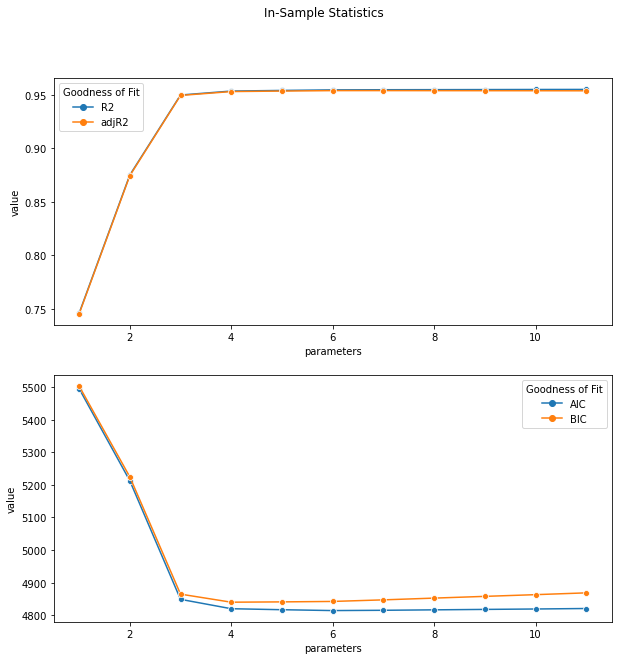

In [18]:
fig, axes = plt.subplots(2,1, figsize=(10,10))

sns.lineplot(x='parameters',y="value", hue='Goodness of Fit', dashes=False, style="Goodness of Fit", markers=["o", "o"],data=dd.loc[dd['Goodness of Fit'].str.contains("R2")],ax=axes[0])

sns.lineplot(x='parameters',y="value", hue='Goodness of Fit', dashes=False, style="Goodness of Fit", markers=["o", "o"],data=dd.loc[~dd['Goodness of Fit'].str.contains("R2")],ax=axes[1])
fig.suptitle("In-Sample Statistics")

plt.show()

### Step 3 of Best Subset Selection
- You can think of this stage in terms of last lecture:
    - You have many models (last time many polynomial models), one for each p
    - But they all maximize the in sample fit
- In step 3, you can do this based on the adjusted-$R^2$, AIC, BIC or you can use CV techniques to find the model that gives the __best out of sample prediction__

In [26]:
models=["intercept",["Rating","intercept"], 
        ["Income","Rating","intercept"],
        ["Income","Rating","Student","intercept"],
        ["Income","Limit","Cards","Student","intercept"],
        ["Income","Limit","Rating","Cards","Student","intercept"],
        ["Income","Limit","Rating","Cards","Age","Student","intercept"],
        ["Income","Limit","Rating","Cards","Age","Gender","Student","intercept"]]

In [27]:
df['intercept']=1
# Best number of predictors using Cross Validation
# use best model from precedent exercise to speed up the code
kfold=5
DFs=[]
kf = KFold(n_splits=kfold, random_state=1706, shuffle=True)

for i,m in enumerate(models):
    MSEs=[] # empty list of MSE scores
    X=df[m].values
    y=df['Balance'].values
    for train_index, test_index in kf.split(X):
        if i==0:
            X_train, X_test = X[train_index].reshape(-1, 1), X[test_index].reshape(-1, 1)
        else:
            X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # regression
        reg = LinearRegression() # initiate the regression class
        reg.fit(X_train,y_train) # fit the data
        # Out of Sample MSE:
        mse=mean_squared_error(y_test, reg.predict(X_test))
        MSEs.append(mse)
    DFs.append(pd.DataFrame({'Predictors':i,'MSE':MSEs}))
    
MSE_scores=pd.concat(DFs)
mse=MSE_scores.groupby('Predictors').mean().reset_index()    
mse

,Predictors,MSE
0,0,211013.906496
1,1,54618.341889
2,2,26576.027671
3,3,10849.538914
4,4,10103.583912
5,5,9981.065488
6,6,9914.381104
7,7,9944.810974


In [39]:
dd_best=pd.concat([models_best_R2, models_best_adjR2, models_best_aic, models_best_bic], axis=1)
dd_best=dd_best.reset_index().rename(columns={'index': 'Predictors'})
dd_best=dd_best.iloc[:len(mse)]
dd_best=dd_best[['Predictors', 'R2', 'adjR2', 'AIC', 'BIC']]
dd_best2=dd_best.merge(mse, on='Predictors')
dd_best2.head()

,Predictors,R2,adjR2,AIC,BIC,MSE
0,1,0.745848,0.745210,5494.781548,5502.764477,54618.341889
1,2,0.875118,0.874489,5212.557085,5224.531479,26576.027671
2,3,0.949879,0.949499,4849.386992,4865.352851,10849.538914
3,4,0.953580,0.953110,4820.701337,4840.658660,10103.583912
4,5,0.954161,0.953579,4817.666820,4841.615607,9981.065488


In [48]:
# Best number of predictors for other statistics
adj_R2_best=int(dd_best2.loc[dd_best2['adjR2']==dd_best2['adjR2'].max(),'Predictors'])
aic_best=int(dd_best2.loc[dd_best2['AIC']==dd_best2['AIC'].min(),'Predictors'])
bic_best=int(dd_best2.loc[dd_best2['BIC']==dd_best2['BIC'].min(),'Predictors'])
mse_best=int(mse.loc[mse.MSE==mse.MSE.min(),'Predictors'])
best_preds=[adj_R2_best,aic_best,bic_best,mse_best]
print(f"Best number of parameters for\nAdjusted R-squared: {adj_R2_best}\nAIC: {aic_best}\nBIC: {bic_best}\n10-fold CV:{mse_best} ")

Best number of parameters for
Adjusted R-squared: 7
AIC: 6
BIC: 4
10-fold CV:6 


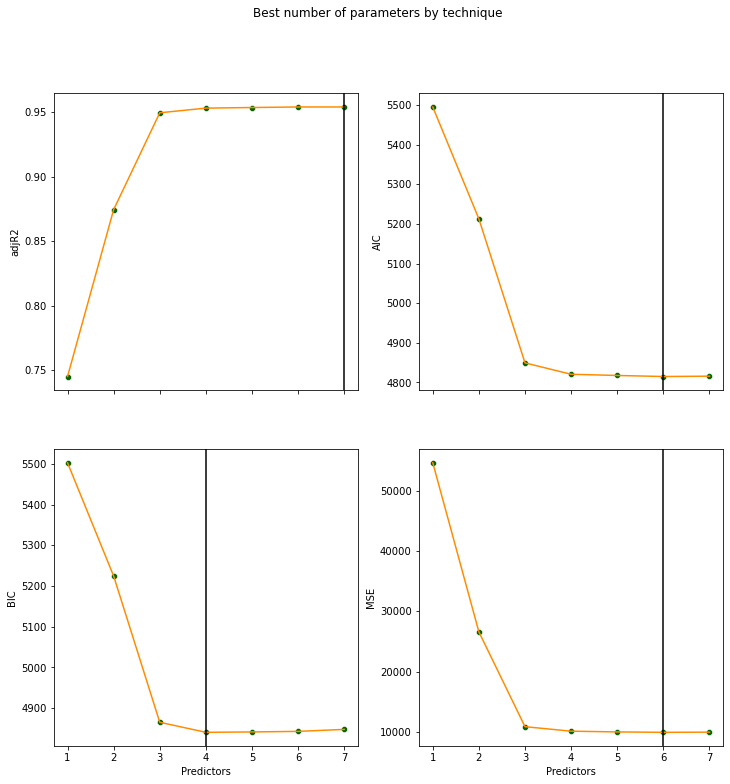

In [49]:
fig, axes = plt.subplots(2,2, figsize=(12,12),sharex=True)
axes = axes.ravel() # access axes with a single position instead of 2
for i, statistics in enumerate(["adjR2","AIC","BIC", "MSE"]):
    sns.lineplot(x='Predictors',y=statistics,data=dd_best2,ax=axes[i], color='darkorange')
    sns.scatterplot(x='Predictors',y=statistics,data=dd_best2,ax=axes[i], color='darkgreen')
#    axes[i].axvline(best_preds[i], color='k')
    axes[i].scatter(x=best_preds[i],y=float(dd_best2.loc[best_preds[i],statistics]),marker='X',color='red',s=100)
#     axes[i].set_ylabel(statistics)
#     axes[i].set_xticks(np.arange(p+1))
fig.suptitle("Best number of parameters by technique")
plt.show()

## Computational challenge
- Best subset selection is a simple and conceptually appealing 
- But the number of possible models that must be considered grows rapidly as p increases. 
- In general, there are $2^p$ models that involve subsets of p predictors. 
    - So if p = 10, then there are approximately 1,000 possible models to be considered!
    - So if p = 20, then there are more than 1,000,000 possible models to be considered!!!

## Solutions to computational challenge: Forward Stepwise Selection

1. Let $\mathscr{M}_0$ denote the null model, which contains no predictors.
2. For $k = 0, \dots , p − 1$:
    - (a) Consider all p − k models that augment the predictors in $\mathscr{M}_k$ with one additional predictor.
    - (b) Choose the best among these p − k models, and call it $\mathscr{M}_{k+1}$.
        - Here best is defined as having smallest RSS or highest R2.
3. Select a single best model from among $\mathscr{M}_0$, $\dots$ ,$\mathscr{M}_p$ using crossvalidated prediction error, AIC, BIC, or adjusted R2.

## Solutions to computational challenge: Backward Stepwise Selection

1. Let $\mathscr{M}_p$ denote the full model, which contains all p predictors.
2. For $k = p, p − 1, \dots , 1$:
    - (a) Consider all k models that contain all but one of the predictors in $\mathscr{M}_k$, for a total of k − 1 predictors.
    - (b) Choose the best among these k models, and call it $\mathscr{M}_{k-1}$. 
        - Here best is defined as having smallest RSS or highest $R^2$.
3. Select a single best model from among $\mathscr{M}_0, \dots ,\mathscr{M}_p$ using crossvalidated prediction error, AIC, BIC, or adjusted R2.

## Taking Stock
- Last week we saw the risks associated with overfitting
- This risk increases with the number of parameters
- Different techniques yield different types of subsets but all penalize, one way or another, having too many parameters
- The trade-off therefore is to find the best out of sample prediction using the least number of predictors possible

# Shrinkage Methods
- Think back on the credit dataset
- The data set has a number of predictors, which all seem reasonable
    - All seem to be legitimate predictors of Balance
    - There no variable irrelevant variable
- Instead of our iterative, and long, process it would be nicer to fit all p predictors using a technique that __constrains__ or __regularizes the coefficient estimates__, or equivalently, that shrinks the coefficient estimates towards zero. 
    - Instead of cherry picking parameters we, instead, force the parameters of redundant predictors to be small or zero

# Ridge Regression
- OLS regression for a model with p parameters finds that $\beta_0, \beta_1, ... \beta_p$ that minimize (as you know):
$$\Large \text{RSS} = \sum_{i=1}^n \Big(y_i - \beta_0 - \sum_{j=1}^p \beta_jx_{ij}\Big)^2$$


## Ridge Regression, continued
- Ridge regression is very similar to least squares, except that the coefficients ridge are by minimizing a slightly different quantity. 
- In particular, the ridge regression coefficient estimates $\hat{\beta^R}$ are the values that minimize:
\begin{gather}
\Large \sum_{i=1}^n \Big(y_i - \beta_0 - \sum_{j=1}^p \beta_jx_{ij}\Big)^2 + \lambda \sum_{j=1}^p\beta_j^2 \\
= \Large\text{RSS} + \lambda \sum_{j=1}^p\beta_j^2
\end{gather}


## Ridge Regression, shrinkage
- $\lambda$ is known as a __tuning parameter__ that is determined outside of the minimization problem
- As with OLS, Ridge regression seeks coefficient estimates that fit the data well (small RSS)
- Unlike OLS, the second term $\lambda \sum_{j=1}^p\beta_j^2$ is small if $\beta_1, ..., \beta_j$ are small ($\beta_0$ not included!)
    - This second term is known as a __shrinkage penalty__
- The tuning parameter $\lambda$ serves to control the relative impact of these two terms on the regression coefficient estimates.
    - When $\lambda$ = 0, the penalty term has no effect, and ridge regression = OLS
    - $\lambda \to \infty$, the impact of the shrinkage penalty grows, and the ridge regression coefficient estimates will approach zero.
- As you will see, the optimal $\lambda$ is given using cross validation

## Standardization of your dataset
- Standardization of datasets is a common requirement for many machine learning estimators implemented see this tutorial in [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html)

- You can transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

- Models such as the Ridge regression assume that all features are centered around zero and have variance in the same order. 
- If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.
- In other words, in the OLS regression, multiplying X by a constant c will change $\beta$ to $\frac{\beta}{c}$
- In the Ridge regression, the $\beta^R$ will depend not only on the value of λ, but also on the scaling of the $j^{th}$ predictor

In [50]:
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Asian,Caucasian,intercept
0,14.891,3606,283,2,34,11,0,0,1,333,0,1,1
1,106.025,6645,483,3,82,15,1,1,1,903,1,0,1
2,104.593,7075,514,4,71,11,0,0,0,580,1,0,1
3,148.924,9504,681,3,36,11,1,0,0,964,1,0,1
4,55.882,4897,357,2,68,16,0,0,1,331,0,1,1


In [51]:
# import the preprocessing module from sklearn
from sklearn import preprocessing
X_train =df[['Income','Limit','Rating','Student','Cards','Age','Education','Gender','Married','Asian','Caucasian']]
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_train.mean(axis=0) , X_train.std(axis=0)

(array([ 0.00000000e+00, -1.59872116e-16,  1.55431223e-17, -5.77315973e-17,
        -1.27675648e-17,  1.77635684e-16,  2.08721929e-16,  4.44089210e-17,
        -2.66453526e-17, -3.55271368e-17,  5.32907052e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

Let's now see what happens to our estimates as the value for $\lambda$ changes

In [52]:
from sklearn.linear_model import Ridge

lambdas = 10**np.linspace(10,-2,100)*0.5
ridge = Ridge()
coefs = []

for 𝜆 in lambdas:
    ridge.set_params(alpha=𝜆)
    ridge.fit(X_train, y)
    coefs.append(ridge.coef_)
ridge_results=pd.DataFrame(coefs,columns=['Income','Limit','Rating','Student','Cards','Age','Education','Gender','Married','Asian','Caucasian'])
ridge_results['Lambda']=lambdas  
ridge_results=pd.melt(ridge_results,id_vars=['Lambda'], var_name='Beta', value_name='Estimate')
ridge_results.head()                           


,Lambda,Beta,Estimate
0,5.000000e+09,Income,0.000017
1,3.782317e+09,Income,0.000023
2,2.861184e+09,Income,0.000030
3,2.164381e+09,Income,0.000039
4,1.637275e+09,Income,0.000052


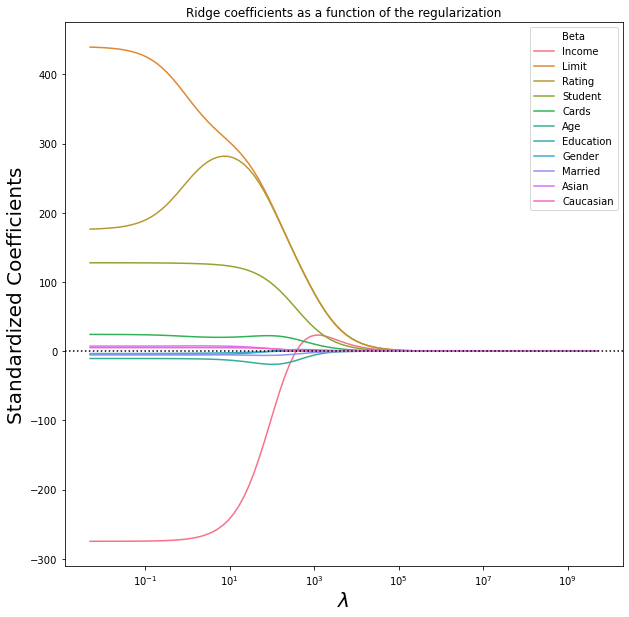

In [53]:
fig, ax =plt.subplots(1,1, figsize=(10,10))
sns.lineplot(x='Lambda', y='Estimate', hue='Beta',data=ridge_results)
ax.set_xscale('log')
ax.axhline(0,color='k',linestyle=":")
plt.axis('tight')
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel('Standardized Coefficients',fontsize=20)
plt.title('Ridge coefficients as a function of the regularization');

## Ridge and Model Selection
- The ridge regression is clearly faster than our best subset methodology
- Note though that we never truly select a model in the sense that we never use a subset of predictors
- Instead, we are shrinking how much they matter in our prediction but use all p predictors (unless λ = ∞).
- This may not be a problem for prediction accuracy, but it can create a challenge in model interpretation in settings in which the number of variables p is quite large. 
- For example, in the Credit data set, it appears that the most important variables are income, limit, rating, and student. 
- So we might wish to build a model including just these predictors. 

## Lasso Regression
- The Lasso regression is an alternative to the Ridge regression as it allows to shrink parmeters to zero
- The lasso regression coefficient estimates $\hat{\beta^L_\lambda}$ are the values that minimize:
\begin{gather}
\Large\text{RSS} + \lambda \sum_{j=1}^p\left|\beta_j\right|
\end{gather}

## Lasso and Model Selection
- As with ridge regression, the lasso shrinks the coefficient estimates towards zero. 
- However, in the case of the lasso, the $\ell_1$ penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter λ is sufficiently large. 
- Hence, much like best subset selection, the lasso performs variable selection.
- We say that the lasso yields __sparse models__ 

In [54]:
from sklearn.linear_model import Lasso

lambdas = 10**np.linspace(10,-2,100)*0.5
lasso = Lasso()
coefs = []

for 𝜆 in lambdas:
    lasso.set_params(alpha=𝜆)
    lasso.fit(X_train, y)
    coefs.append(lasso.coef_)
lasso_results=pd.DataFrame(coefs,columns=['Income','Limit','Rating','Student','Cards','Age','Education','Gender','Married','Asian','Caucasian'])
lasso_results['Lambda']=lambdas  
lasso_results=pd.melt(lasso_results,id_vars=['Lambda'], var_name='Beta', value_name='Estimate')
lasso_results.head()                        


/Users/forgef/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17920.893739334773, tolerance: 8433.991191
  model = cd_fast.enet_coordinate_descent(


,Lambda,Beta,Estimate
0,5.000000e+09,Income,0.0
1,3.782317e+09,Income,0.0
2,2.861184e+09,Income,0.0
3,2.164381e+09,Income,0.0
4,1.637275e+09,Income,0.0


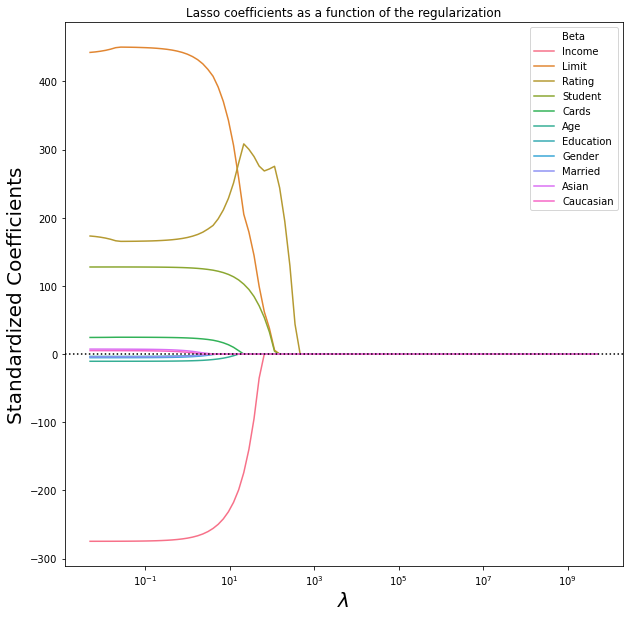

In [55]:
fig, ax =plt.subplots(1,1, figsize=(10,10))
ax = plt.gca()
sns.lineplot(x='Lambda', y='Estimate', hue='Beta',data=lasso_results)
ax.set_xscale('log')
ax.axhline(0,color='k',linestyle=":")
plt.axis('tight')
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel('Standardized Coefficients',fontsize=20)
plt.title('Lasso coefficients as a function of the regularization');

## Another Formulation for Ridge Regression and the Lasso
- You may have recognized something you are already familiar with as economists
- The Lasso and Ridge regressions can be written in terms of objective function (to minimize) and a constraint
 
 __Ridge__:
 \begin{gather}
 \large \min_{\mathbf{\beta}} \left\{ \sum_{i=1}^n \Big(y_i - \beta_0 - \sum_{j=1}^p \beta_jx_{ij}\Big)^2 \right\} \\ \large \text{subject to } \ \sum_{j=1}^p\beta_j^2 \leq s
 \end{gather}
 
 __Lasso__:
  \begin{gather}
 \large \min_{\mathbf{\beta}} \left\{ \sum_{i=1}^n \Big(y_i - \beta_0 - \sum_{j=1}^p \beta_jx_{ij}\Big)^2 \right\} \\ \large \text{subject to } \ \sum_{j=1}^p\left|\beta_j\right| \leq s
 \end{gather}


## Another Formulation for Ridge Regression and the Lasso, continued

- The formulas in the previous slide mean that for every value of λ, there is some s such that the constraint minization yields the same result as our first definition of Lasso and Ridge
- When p=2 (2 predictors): 
    - the lasso coefficient estimates have the smallest RSS such that $\left|\beta_1\right|+ \left|\beta_2\right| \leq s $
    - the ridge coefficient estimates have the smallest RSS such that $\beta_1^2 + \beta_2^2 \leq s$

- We can think of it as follows.
    - When we perform the Lasso or Ridge we are trying to find the set of coefficient estimates that lead to the smallest RSS, subject to the constraint that there is a budget s for how large $\sum_{j=1}^p \left|\beta_j\right|$ or 
$\sum_{j=1}^p \beta_j^2$ can be.

- If s is large the restriction is not binding (not restrictive)
- For s large enough you get the OLS estimates (which are unconstrained)

![title](lasso_ridge.png)

## OLS vs Ridge and Lasso
- In the previous slide, the OLS solution is marked as $\hat{\beta}$ and lies outside the constraint
- If s was sufficiently large, Ridge and Lasso estimates would be the same as OLS (case where $\lambda=0$)
- The ellipses that are centered around $\hat{\beta}$ represent regions of constant RSS. 
- As the ellipses expand away from the least squares coefficient estimates, the RSS increases. 
- The lasso and ridge regression coefficient estimates are given by the first point at which an ellipse contacts the constraint region. 
- Since ridge regression has a circular constraint with no sharp points, this intersection will not generally occur on an axis, and so the ridge regression coefficient estimates will be exclusively non-zero. 
- However, the lasso constraint has corners at each of the axes, and so the ellipse will often intersect the constraint region at an axis. When this occurs, one of the coefficients will equal
     - Here, the intersection occurs at β1 = 0, and so theresulting model will only include β2.

## Selecting the tuning parameter
- Since a lot seems to depend on the value of $\lambda$ which value should you choose?
- As usual, we need to remember that our end goal is to maximize out of sample prediction
- As such the right model and/or the right tuning parameter will be given by cross validation

![image.png](lasso_lambda.png)